# **Cálculos Simulación**

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import t
from scipy.stats import norm
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Ventas categorizadas y asignación resultante
bdd_ventas = pd.read_excel("BDD_Bodegas_Categorizada_proy.xlsx")
bdd_asignaciones = pd.read_excel("Resultados/Pre-Informe/datos_aloc_p_3_manhattan_proy.xlsx")
bdd_ventas['Fecha'] = pd.to_datetime(bdd_ventas['Fecha'])
bdd_ventas['Semana'] = bdd_ventas['Fecha'].dt.strftime('%U')
bdd_ventas['Año'] = bdd_ventas['Fecha'].dt.year
bdd_ventas['Año-Sem'] = bdd_ventas['Año'].astype(str) + "-" + bdd_ventas['Semana'].astype(str)
bdd_asignaciones = bdd_asignaciones.drop(columns=['Cantidad'])

# Comunas
bdd_comunas = pd.read_excel("BDD_Bodegas.xlsx", sheet_name=3)

# Agrupación de ventas por cliente 
bdd_ventas_agrupadas = bdd_ventas.groupby(['ID Cliente', 'Año-Sem']).agg({"Cantidad": "sum", 'Categoria': 'first'}).reset_index()
bdd_ventas_agrupadas['Cantidad'] = bdd_ventas_agrupadas['Cantidad'].apply(lambda x: 0.01 if x == 0 else x)
bdd_proyeccion = bdd_ventas_agrupadas.merge(bdd_asignaciones, right_on = "Unnamed: 0", left_on ="ID Cliente")

## Resultados
resultado_3 = bdd_proyeccion.groupby(['Bodega Asignada', 'Año-Sem'])['Cantidad'].sum().reset_index()
resultado_3["Semana"] = resultado_3["Año-Sem"].str.split("-").str[1]
resultado_3["Año"] = resultado_3["Año-Sem"].str.split("-").str[0]

# Resultados por bodega
bodegas = {1: resultado_3[resultado_3["Bodega Asignada"]==1], 4: resultado_3[resultado_3["Bodega Asignada"]==4], 8: resultado_3[resultado_3["Bodega Asignada"]==8]}

# Filtramos los años de proyección
resultado_3 = resultado_3[resultado_3["Año"] > "2030"]

# Hacemos 3 dataframes, uno por bodega
bod_1 = resultado_3[resultado_3["Bodega Asignada"] == 1]
bod_4 = resultado_3[resultado_3["Bodega Asignada"] == 4]
bod_8 = resultado_3[resultado_3["Bodega Asignada"] == 8]

# Definimos una función para simplificar el filtrado por semana
def filtrar_semana(df, semanas_alto, semanas_promedio):
    df_alto = df[df["Semana"].astype(int).isin(semanas_alto)]
    df_promedio = df[df["Semana"].astype(int).isin(semanas_promedio)]
    return df_alto, df_promedio

# Definimos las semanas altas y promedio para cada bodega
semanas_alto_bod_1 = [1, 2, 3, 4, 15, 16, 17, 18, 19, 20, 21, 22, 23, 42, 43, 44, 45, 46, 47, 48, 49, 50]
semanas_promedio_bod_1 = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 51, 52]

semanas_alto_bod_4 = [1, 2, 3, 4, 14, 15, 16, 17, 18, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 42, 43]
semanas_promedio_bod_4 = [5, 6, 7, 8, 9, 10, 11, 12, 13, 19, 20, 21, 22, 23, 24, 36, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52]

semanas_alto_bod_8 = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
semanas_promedio_bod_8 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 22, 23, 24, 25, 26, 27, 28, 29, 30, 47, 48, 49, 50, 51, 52]

lista_semanas = [semanas_alto_bod_1, semanas_promedio_bod_1, semanas_alto_bod_4, semanas_promedio_bod_4, semanas_alto_bod_8, semanas_promedio_bod_8]

# Aplicamos la función de filtrado por semana a cada bodega
bod_1_alto, bod_1_prom = filtrar_semana(bod_1, semanas_alto_bod_1, semanas_promedio_bod_1)
bod_4_alto, bod_4_prom = filtrar_semana(bod_4, semanas_alto_bod_4, semanas_promedio_bod_4)
bod_8_alto, bod_8_prom = filtrar_semana(bod_8, semanas_alto_bod_8, semanas_promedio_bod_8)

lista_bdd = [bod_1_alto, bod_1_prom, bod_4_alto, bod_4_prom, bod_8_alto, bod_8_prom]
nombres_bdd = ["bod_1_alto", "bod_1_prom", "bod_4_alto", "bod_4_prom", "bod_8_alto", "bod_8_prom"]

mejores_distribuciones = []

for i, b in enumerate(lista_bdd):
    
    nombre = nombres_bdd[i]
    
    # Ordeno por cantidad la base de datos
    b = b.sort_values(by=['Cantidad'], ascending=True)
    demanda = b['Cantidad']

    # Lista de distribuciones a ajustar
    distribuciones = [stats.norm, stats.expon, stats.geom, stats.t, stats.lognorm, stats.chi2, stats.beta, stats.gamma, stats.pareto]

    # Inicializamos valores
    mejor_distribucion = None
    mejor_params = ()
    mejor_kstest = float('inf')

    # Iteramos para las distintas distribuciones
    for distribucion in distribuciones:
        if distribucion == stats.geom:
            # Estimación para la distribución geométrica (funciona distinto a las demás)
            p_geom = 1 - np.mean(demanda)
            params = (p_geom,)
        else:
            # Estimación de los parámetros 
            params = distribucion.fit(demanda)
        
        ks_statistic, ks_p_value = stats.kstest(demanda, distribucion.name, params)
        
        # Compara el estadístico KS con el mejor encontrado hasta ahora
        if ks_statistic < mejor_kstest:
            mejor_distribucion = distribucion
            mejor_params = params
            mejor_kstest = ks_statistic

    # Actualizar lista de mejores distribuciones
    mejores_distribuciones.append([nombre, mejor_distribucion.name, mejor_params])
    
def dist_gamma(a, b, c, n):
    # Parámetros de la distribución gamma
    a, loc, scale = a,b,c

    # Generar 1000 muestras de la distribución gamma
    muestras = gamma.rvs(a, loc=loc, scale=scale, size=n)

    return muestras


def dist_expon(a,b, n):

    # Parámetros de la distribución exponencial
    loc, scale = a, b

    # Generar 1000 muestras de la distribución exponencial
    muestras = expon.rvs(loc=loc, scale=scale, size=n)

    return muestras

def dist_t(a,b,c, n):
    # Parámetros de la distribución t de Student
    df, loc, scale = a, b, c

    # Generar 1000 muestras de la distribución t de Student
    muestras = t.rvs(df, loc=loc, scale=scale, size=n)

    return muestras

def dist_norm(a,b, n):
    # Parámetros de la distribución normal
    loc, scale = a, b

    # Generar 1000 muestras de la distribución normal
    muestras = norm.rvs(loc=loc, scale=scale, size=n)

    return muestras

# Ahora código de simulación para cada bodega, considerando un número proporcional de semanas según se cantidad

def crear_demanda():

    dataframes = []

    # Simulamos para cada bodega
    for i, bdd in enumerate(lista_bdd):
        nombre = nombres_bdd[i]
        distribucion = mejores_distribuciones[i][1]
        parametros = mejores_distribuciones[i][2]
        cant_simulaciones = int(len(lista_semanas[i]))
        if distribucion == "gamma":
            dataframes.append(dist_gamma(parametros[0], parametros[1], parametros[2], cant_simulaciones))
        elif distribucion == "expon":
            dataframes.append(dist_expon(parametros[0], parametros[1], cant_simulaciones))
        elif distribucion == "t":
            dataframes.append(dist_t(parametros[0], parametros[1], parametros[2], cant_simulaciones))
        elif distribucion == "norm":
            dataframes.append(dist_norm(parametros[0], parametros[1], cant_simulaciones))

    # Resultados para cada bodega
    bod_1 = pd.concat([pd.DataFrame(dataframes[0]), pd.DataFrame(dataframes[1])])
    bod_4 = pd.concat([pd.DataFrame(dataframes[2]), pd.DataFrame(dataframes[3])])
    bod_8 = pd.concat([pd.DataFrame(dataframes[4]), pd.DataFrame(dataframes[5])])

    # Creamos una columna de "Bodega" a cada df
    bod_1["Bodega Asignada"] = 1
    bod_4["Bodega Asignada"] = 4
    bod_8["Bodega Asignada"] = 8

    # Creamos columna semana del 1 al 52
    bod_1["Semana"] = np.arange(1, 53)
    bod_4["Semana"] = np.arange(1, 53)
    bod_8["Semana"] = np.arange(1, 53)

    # Cambiamos el nombre de la columna de la cantidad
    bod_1_sim = bod_1.rename(columns={0: "Cantidad"})
    bod_4_sim = bod_4.rename(columns={0: "Cantidad"})
    bod_8_sim = bod_8.rename(columns={0: "Cantidad"})

    # Juntamos todo
    simulacion = pd.concat([bod_1_sim, bod_4_sim, bod_8_sim])
    simulacion = simulacion.reset_index(drop=True)

    orden = ['Bodega Asignada', 'Semana', 'Cantidad']  # Define el nuevo orden de las columnas

    simulacion = simulacion[orden]

    return simulacion

c:\Users\alvar\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


In [3]:
def semanas_sobreocupacion(demanda, tamaños_bodegas, numero_bodega):
    tamaño = tamaños_bodegas[numero_bodega]
    bdd = demanda[demanda["Bodega Asignada"] == numero_bodega]
    camiones_a_pedir = 0
    for i in range(len(bdd)):
        camiones_a_pedir += math.ceil(bdd.iloc[i,2]/tamaño)
    return camiones_a_pedir

def calcular_costos(demanda, tamaños_bodegas, numero_bodega):
    distancias = {1: 372.52, 4: 189.66, 8: 600.62}
    tamaño = tamaños_bodegas[numero_bodega]
    camiones = semanas_sobreocupacion(demanda, tamaños_bodegas, numero_bodega)
    costo_fijo = 36700*tamaño/1000000
    costo_tpte = 1200*distancias[numero_bodega]*camiones/1000000 
    costo_total = costo_fijo + costo_tpte
    return costo_fijo, costo_tpte, costo_total

In [4]:
def simulación(n):
    costos_tpte_1 = list()
    costos_tpte_4 = list()
    costos_tpte_8 = list()
    costos_totales_1 = list()
    costos_totales_4 = list()
    costos_totales_8 = list()

    for i in range(n):
        df_bodegas = crear_demanda()

        costos_bodega_1 = calcular_costos(df_bodegas, tamaños_bodegas, 1)
        costos_tpte_1.append(costos_bodega_1[1])
        costos_totales_1.append(costos_bodega_1[2])

        costos_bodega_4 = calcular_costos(df_bodegas, tamaños_bodegas, 4)
        costos_tpte_4.append(costos_bodega_4[1])
        costos_totales_4.append(costos_bodega_4[2])
        
        costos_bodega_8 = calcular_costos(df_bodegas, tamaños_bodegas, 8)
        costos_tpte_8.append(costos_bodega_8[1])
        costos_totales_8.append(costos_bodega_8[2])

    return costos_tpte_1, costos_totales_1, costos_tpte_4, costos_totales_4, costos_tpte_8, costos_totales_8

In [5]:
def F(lista, n):
    count = 0
    for element in lista:
        if element <= n:
            count += 1
    percentage = (count / len(lista)) * 100
    return percentage

In [6]:
tamaños_bodegas = {1: 1909.98, 4: 4660.66, 8: 4398.43}
costos = simulación(10000)

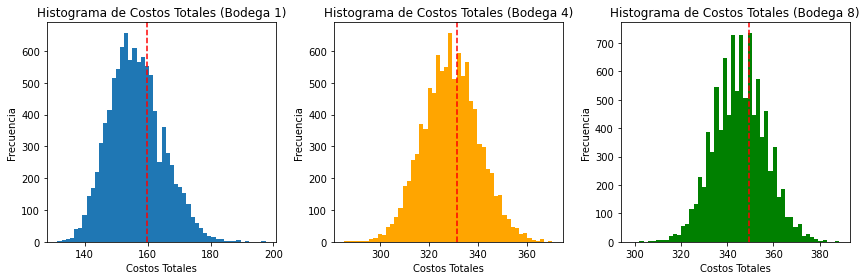

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4)) 

# Bodega 1 - Costos Totales
axs[0].hist(costos[1], bins=50)
axs[0].axvline(x=159.95, color='red', linestyle='dashed')
axs[0].set_xlabel('Costos Totales')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Histograma de Costos Totales (Bodega 1)')

# Bodega 4 - Costos Totales
axs[1].hist(costos[3], bins=50, color='orange')
axs[1].axvline(x=331.27, color='red', linestyle='dashed')
axs[1].set_xlabel('Costos Totales')
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Histograma de Costos Totales (Bodega 4)')

# Bodega 8 - Costos Totales
axs[2].hist(costos[5], bins=50, color='green')
axs[2].axvline(x=349.54, color='red', linestyle='dashed')
axs[2].set_xlabel('Costos Totales')
axs[2].set_ylabel('Frecuencia')
axs[2].set_title('Histograma de Costos Totales (Bodega 8)')

plt.tight_layout()
plt.show()


In [35]:
print(F(costos[1], 171.2))
print(F(costos[3], 348.0))
print(F(costos[5], 363.3))

95.22
95.05
95.23


In [93]:
tamaños_bodegas = {1: 1500, 4: 3900, 8: 3800}
costos_disminuidos = simulación(10000)

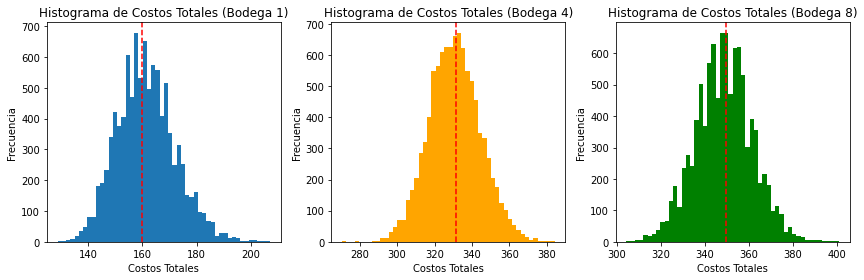

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4)) 

# Bodega 1 - Costos Totales
axs[0].hist(costos_disminuidos[1], bins=50)
axs[0].axvline(x=159.95, color='red', linestyle='dashed')
axs[0].set_xlabel('Costos Totales')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Histograma de Costos Totales (Bodega 1)')

# Bodega 4 - Costos Totales
axs[1].hist(costos_disminuidos[3], bins=50, color='orange')
axs[1].axvline(x=331.27, color='red', linestyle='dashed')
axs[1].set_xlabel('Costos Totales')
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Histograma de Costos Totales (Bodega 4)')

# Bodega 8 - Costos Totales
axs[2].hist(costos_disminuidos[5], bins=50, color='green')
axs[2].axvline(x=349.54, color='red', linestyle='dashed')
axs[2].set_xlabel('Costos Totales')
axs[2].set_ylabel('Frecuencia')
axs[2].set_title('Histograma de Costos Totales (Bodega 8)')

plt.tight_layout()
plt.show()

In [117]:
print(F(costos_disminuidos[1], 159.95))
print(F(costos_disminuidos[3], 331.27))
print(F(costos_disminuidos[5], 349.54))

47.13
51.77
52.1


In [120]:
tamaños_bodegas = {1: 1800, 4: 4600, 8: 4300}
costos_disminuidos2 = simulación(1000)

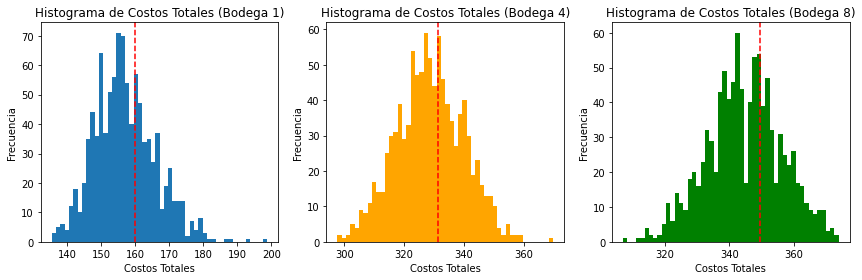

In [122]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4)) 

# Bodega 1 - Costos Totales
axs[0].hist(costos_disminuidos2[1], bins=50)
axs[0].axvline(x=159.95, color='red', linestyle='dashed')
axs[0].set_xlabel('Costos Totales')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Histograma de Costos Totales (Bodega 1)')

# Bodega 4 - Costos Totales
axs[1].hist(costos_disminuidos2[3], bins=50, color='orange')
axs[1].axvline(x=331.27, color='red', linestyle='dashed')
axs[1].set_xlabel('Costos Totales')
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Histograma de Costos Totales (Bodega 4)')

# Bodega 8 - Costos Totales
axs[2].hist(costos_disminuidos2[5], bins=50, color='green')
axs[2].axvline(x=349.54, color='red', linestyle='dashed')
axs[2].set_xlabel('Costos Totales')
axs[2].set_ylabel('Frecuencia')
axs[2].set_title('Histograma de Costos Totales (Bodega 8)')

plt.tight_layout()
plt.show()

Tamaños Óptimos Caso Futuro LAP

![A](Tamaños_Caso_Futuro_LAP.jpg)